In [133]:
%pip install aif360
%pip install 'aif360[Reductions]'
%pip install 'aif360[LawSchoolGPA]'

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [134]:
import sys 
import os  
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from collections import OrderedDict

from sklearn.model_selection import train_test_split

from aif360.algorithms.preprocessing.optim_preproc import OptimPreproc
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
            import load_preproc_data_adult, load_preproc_data_german, load_preproc_data_compas
from aif360.algorithms.preprocessing.optim_preproc_helpers.distortion_functions\
            import get_distortion_adult, get_distortion_german, get_distortion_compas
from aif360.algorithms.preprocessing.optim_preproc_helpers.opt_tools import OptTools
import aif360.metrics 

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

import aif360.datasets
import aif360.algorithms.preprocessing
import aif360.algorithms.inprocessing
import aif360.algorithms.postprocessing
from IPython.display import Markdown, display
from aif360.algorithms.inprocessing import MetaFairClassifier
from aif360.algorithms.preprocessing import Reweighing
from sklearn.model_selection import train_test_split

from aif360.metrics import ClassificationMetric

import tensorflow as tf
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()

def compute_metrics(dataset_true, dataset_pred, 
                    unprivileged_groups, privileged_groups,
                    disp = True):
    """ Compute the key metrics """
    classified_metric_pred = ClassificationMetric(dataset_true,
                                                 dataset_pred, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    metrics = OrderedDict()
    metrics["Balanced accuracy"] = 0.5*(classified_metric_pred.true_positive_rate()+
                                             classified_metric_pred.true_negative_rate())
    metrics["Statistical parity difference"] = classified_metric_pred.statistical_parity_difference()
    metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
    metrics["Average odds difference"] = classified_metric_pred.average_odds_difference()
    metrics["Equal opportunity difference"] = classified_metric_pred.equal_opportunity_difference()
    metrics["Theil index"] = classified_metric_pred.theil_index()
    
    if disp:
        for k in metrics:
            print("%s = %.4f" % (k, metrics[k]))
    
    return metrics

In [135]:

from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing.optim_preproc import \
        OptimPreproc
from aif360.algorithms.preprocessing.optim_preproc_helpers. \
        data_preproc_functions import load_preproc_data_adult
from aif360.algorithms.preprocessing.optim_preproc_helpers. \
        distortion_functions import get_distortion_adult
from aif360.algorithms.preprocessing.optim_preproc_helpers. \
        opt_tools import OptTools


In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Markdown, display
str = '# Start'
display(Markdown(str+' Coding'))

# Start Coding

In [137]:
data_ricci=pd.read_csv('data/Ricci/ricci_processed.csv')
data_ricci

,Position,Oral,Written,Race,Combine,Promotion
0,Captain,89.52,95,W,92.808,Promotion
1,Captain,80.00,95,W,89.000,Promotion
2,Captain,82.38,87,W,85.152,Promotion
3,Captain,88.57,76,W,81.028,Promotion
4,Captain,76.19,84,W,80.876,Promotion
...,...,...,...,...,...,...
113,Lieutenant,40.83,64,H,54.732,No promotion
114,Lieutenant,52.08,56,B,54.432,No promotion
115,Lieutenant,48.33,58,H,54.132,No promotion
116,Lieutenant,52.92,49,B,50.568,No promotion


In [138]:
data_ricci.groupby('Race').describe()

Oral                                                              \
     count       mean        std    min     25%    50%      75%    max   
Race                                                                     
B     27.0  63.952222  10.974650  45.83  55.415  61.25  70.6550  92.08   
H     23.0  57.036957  10.990928  40.83  49.375  56.25  64.8200  79.05   
W     68.0  69.017647  12.039179  44.58  58.645  71.67  77.7075  89.52   

     Written             ...              Combine                       \
       count       mean  ...    75%   max   count       mean       std   
Race                     ...                                             
B       27.0  63.592593  ...  71.50  86.0    27.0  63.736444  8.744066   
H       23.0  70.869565  ...  73.50  84.0    23.0  65.336522  7.142540   
W       68.0  75.117647  ...  82.25  95.0    68.0  72.677647  8.834185   

                                              
         min     25%     50%     75%     max  
Race                                          
B     45.932  57.662  61.068  72.030  76.600  
H     54.132  60.078  65.000  69.946  79.676  
W     56.324  68.015  71.642  78.451  92.808  

[3 rows x 24 columns]

In [139]:
data_ricci.groupby(['Position', 'Race']).describe()['Combine']

count       mean       std     min     25%     50%     75%  \
Position   Race                                                               
Captain    B       8.0  63.782000  8.492689  51.304  57.594  63.900  70.742   
           H       8.0  68.546500  8.701684  57.344  61.685  67.524  76.615   
           W      25.0  74.112800  8.251842  56.324  69.372  73.732  78.124   
Lieutenant B      19.0  63.717263  9.076899  45.932  58.132  61.068  72.482   
           H      15.0  63.624533  5.768875  54.132  60.000  63.268  68.666   
           W      43.0  71.843256  9.145921  56.632  66.434  70.732  78.766   

                    max  
Position   Race          
Captain    B     74.952  
           H     79.676  
           W     92.808  
Lieutenant B     76.600  
           H     71.200  
           W     90.100

# aif360

## Pre Processing

In [140]:
import aif360
import aif360.metrics
import aif360.datasets

In [141]:
data_ricci=pd.read_csv('data/Ricci/ricci_processed.csv')
pre_proc_dataset= data_ricci.replace(['W','B','H','Captain','Lieutenant'],[1,0,0,1,0])
pre_proc_dataset= pre_proc_dataset.replace(['Promotion','No promotion'],[1,0])

In [142]:
pre_proc_dataset['Oral']= (pre_proc_dataset['Oral']-min(pre_proc_dataset['Oral']))/(max(pre_proc_dataset['Oral'])-min(pre_proc_dataset['Oral']))
pre_proc_dataset['Written']= (pre_proc_dataset['Written']-min(pre_proc_dataset['Written']))/(max(pre_proc_dataset['Written'])-min(pre_proc_dataset['Written']))
pre_proc_dataset['Combine']= (pre_proc_dataset['Combine']-min(pre_proc_dataset['Combine']))/(max(pre_proc_dataset['Combine'])-min(pre_proc_dataset['Combine']))
pre_proc_dataset.head()

,Position,Oral,Written,Race,Combine,Promotion
0,1,0.950049,1.000000,1,1.000000,1
1,1,0.764293,1.000000,1,0.918764,1
2,1,0.810732,0.836735,1,0.836675,1
3,1,0.931512,0.612245,1,0.748699,1
4,1,0.689951,0.775510,1,0.745456,1


In [143]:
pre_proc_dataset[pre_proc_dataset.Race==1][pre_proc_dataset.Promotion==1].shape[0]

/var/folders/lc/x5z01dj94tx8cvz5yhryw4vm0000gn/T/ipykernel_33110/1690238757.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pre_proc_dataset[pre_proc_dataset.Race==1][pre_proc_dataset.Promotion==1].shape[0]


41

68
50


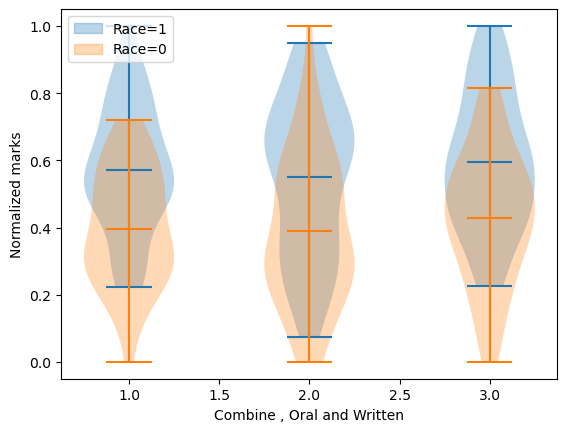

In [144]:
white_data=pre_proc_dataset[pre_proc_dataset.Race==1][['Combine','Oral','Written']]
print(white_data.shape[0])
other_data=pre_proc_dataset[pre_proc_dataset.Race==0][['Combine','Oral','Written']]
print(other_data.shape[0])
import matplotlib.patches as mpatches
labels = []
def add_label(violin, label):
    color = violin["bodies"][0].get_facecolor().flatten()
    labels.append((mpatches.Patch(color=color), label))

add_label(plt.violinplot(white_data,showmeans=True,showextrema=True), "Race=1")
add_label(plt.violinplot(other_data,showmeans=True,showextrema=True), "Race=0")

plt.ylabel('Normalized marks')
plt.xlabel('Combine , Oral and Written')


plt.legend(*zip(*labels), loc=2)
plt.savefig('fig/marks.png')

In [145]:
sensitive_attribute = 'Race'
protected_attribute= ['Race']
privileged_group = [{'Race':1}]
unprivileged_group = [{'Race':0}]

In [146]:
dataset_orig_train, dataset_orig_test = train_test_split(pre_proc_dataset, test_size=0.5)
#dataset_orig_valid, dataset_orig_test = train_test_split(pre_proc_dataset, test_size=0.5)

In [147]:
dataset_orig_train_bin = aif360.datasets.BinaryLabelDataset(favorable_label=1, 
                                 unfavorable_label=0,
                                 df = dataset_orig_train, 
                                 label_names= ['Promotion'], 
                                 protected_attribute_names=protected_attribute)

dataset_orig_test_bin = aif360.datasets.BinaryLabelDataset(favorable_label=1, 
                                 unfavorable_label=0,
                                 df = dataset_orig_test, 
                                 label_names= ['Promotion'], 
                                 protected_attribute_names=protected_attribute
                                 )


We can define our metric with a BinaryLabelDatasetMetric ;

In [148]:
metric_orig_train = aif360.metrics.BinaryLabelDatasetMetric(dataset_orig_train_bin, 
                                         unprivileged_groups=unprivileged_group,
                                         privileged_groups=privileged_group)
display(Markdown("#### Original train dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())
print("Disparate impact = %f" % metric_orig_train.disparate_impact())

#### Original train dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.496528
Disparate impact = 0.309179


Here we can understand that 20% of the privileged group (white race) is getting more positives outcomes in the training dataset. this is unwanted. So we are going to do some mitigation of this bias by reweighing the dataset. 
**Reweighing** transforms the dataset to have more equity between the privileged and unpivileged groups

In [149]:
reweigh = Reweighing(unprivileged_groups=unprivileged_group,
                     privileged_groups=privileged_group)

dataset_transf_train = reweigh.fit_transform(dataset_orig_test_bin)
dataset_transf_train = dataset_orig_train_bin.align_datasets(dataset_transf_train)

dataset_transf_test = reweigh.fit_transform(dataset_orig_test_bin)
dataset_transf_test = dataset_orig_train_bin.align_datasets(dataset_transf_test)

In [150]:
metric_transf_train = aif360.metrics.BinaryLabelDatasetMetric(dataset_transf_train, 
                                         unprivileged_groups=unprivileged_group,
                                         privileged_groups=privileged_group)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.000000


We can see that with the reweighing the mean outcome between the prvileged and the unprivileged was reduced to 0. So the dataset has now more equity between the privileged and unprivileged group.


In [151]:
results=pd.DataFrame(index=['Mean difference','Disparate impact'])

## Data Loading and test with the original test

Now we are going to load test data

In [152]:
dataset_orig_test = dataset_transf_train.align_datasets(dataset_orig_test_bin)

metric_orig_test = aif360.metrics.BinaryLabelDatasetMetric(dataset_orig_test_bin, 
                                         unprivileged_groups=unprivileged_group,
                                         privileged_groups=privileged_group)

display(Markdown("#### Original test dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())
print("Disparate impact = %f" % metric_orig_test.disparate_impact())
results['Original']=metric_orig_test.mean_difference(),metric_orig_test.disparate_impact()

#### Original test dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.108696
Disparate impact = 0.782609


In [153]:
dataset_transf_test = reweigh.transform(dataset_orig_test_bin)
dataset_transf_test= dataset_orig_test_bin.align_datasets(dataset_transf_train)

metric_transf_test = aif360.metrics.BinaryLabelDatasetMetric(dataset_transf_test, 
                                         unprivileged_groups=unprivileged_group,
                                         privileged_groups=privileged_group)

display(Markdown("#### Transformed test dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_test.mean_difference())
print("Disparate impact = %f" % metric_transf_test.disparate_impact())

#### Transformed test dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.000000
Disparate impact = 1.000000


# Prediction

## Reweight + Logistic regression

### Original dataset

In [154]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_train_bin.features)
y_train = dataset_orig_train_bin.labels.ravel()

X_test= scale_orig.fit_transform(dataset_orig_test_bin.features)
y_test= dataset_orig_test_bin.labels.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train)
y_train_pred = lmod.predict(X_train)

y_test_pred=lmod.predict(X_test)
# positive class index
pos_ind = np.where(lmod.classes_ == dataset_orig_train_bin.favorable_label)[0][0]

dataset_orig_train_pred = dataset_orig_train_bin.copy()
dataset_orig_train_pred.labels = y_train_pred

train_acc=(y_train==y_train_pred).sum()/y_train.shape[0]
print("Training accuracy =%f" %train_acc)

test_acc=(y_test_pred==y_test).sum()/y_test.shape[0]
print("Testing accuracy = %f"%test_acc)

Training accuracy =1.000000
Testing accuracy = 0.898305


### Tranformed dataset

In [155]:
dataset_transf_train
dataset_transf_test

scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_transf_train.features)
y_train = dataset_transf_train.labels.ravel()

X_test= scale_orig.fit_transform(dataset_transf_test.features)
y_test= dataset_transf_test.labels.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train)
y_train_pred = lmod.predict(X_train)

y_test_pred=lmod.predict(X_test)

In [156]:
test_data_pred=dataset_transf_test.copy()
test_data_pred.labels=y_test_pred

In [157]:
metric_test_pred = aif360.metrics.BinaryLabelDatasetMetric(test_data_pred, 
                                         unprivileged_groups=unprivileged_group,
                                         privileged_groups=privileged_group)

print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_test_pred.mean_difference())
print("Disparate impact = %f" % metric_test_pred.disparate_impact())

train_acc=(y_train==y_train_pred).sum()/y_train.shape[0]
print("Training accuracy =%f" %train_acc)

test_acc=(y_test_pred==y_test).sum()/y_test.shape[0]
print("Testing accuracy = %f"%test_acc)

results['RW+Rlog']=metric_test_pred.mean_difference(),metric_test_pred.disparate_impact()

Difference in mean outcomes between unprivileged and privileged groups = 0.025424
Disparate impact = 1.058824
Training accuracy =0.983051
Testing accuracy = 0.983051


## Reweight + Random forest

### Original dataset

In [158]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_train_bin.features)
y_train = dataset_orig_train_bin.labels.ravel()

X_test= scale_orig.fit_transform(dataset_orig_test_bin.features)
y_test= dataset_orig_test_bin.labels.ravel()

randf = RandomForestClassifier(n_estimators=500)
randf.fit(X_train, y_train)
y_train_pred = randf.predict(X_train)

y_test_pred=randf.predict(X_test)
# positive class index
pos_ind = np.where(randf.classes_ == dataset_orig_train_bin.favorable_label)[0][0]

dataset_orig_train_pred = dataset_orig_train_bin.copy()
dataset_orig_train_pred.labels = y_train_pred

train_acc=(y_train==y_train_pred).sum()/y_train.shape[0]
print("Training accuracy =%f" %train_acc)

test_acc=(y_test_pred==y_test).sum()/y_test.shape[0]
print("Testing accuracy = %f"%test_acc)

Training accuracy =1.000000
Testing accuracy = 0.966102


### Transformed dataset

In [159]:
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_transf_train.features)
y_train = dataset_transf_train.labels.ravel()

X_test= scale_orig.fit_transform(dataset_transf_test.features)
y_test= dataset_transf_test.labels.ravel()

randf = RandomForestClassifier(n_estimators=500)
randf.fit(X_train, y_train)
y_train_pred = randf.predict(X_train)

y_test_pred=randf.predict(X_test)

In [160]:
test_data_pred=dataset_transf_test.copy()
test_data_pred.labels=y_test_pred

In [161]:
metric_test_pred = aif360.metrics.BinaryLabelDatasetMetric(test_data_pred, 
                                         unprivileged_groups=unprivileged_group,
                                         privileged_groups=privileged_group)

print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_test_pred.mean_difference())
print("Disparate impact = %f" % metric_test_pred.disparate_impact())

train_acc=(y_train==y_train_pred).sum()/y_train.shape[0]
print("Training accuracy =%f" %train_acc)

test_acc=(y_test_pred==y_test).sum()/y_test.shape[0]
print("Testing accuracy = %f"%test_acc)

results['RW+RandFor']=metric_test_pred.mean_difference(),metric_test_pred.disparate_impact()

Difference in mean outcomes between unprivileged and privileged groups = 0.000000
Disparate impact = 1.000000
Training accuracy =1.000000
Testing accuracy = 1.000000


## Grid Search Reduction

In [162]:
from aif360.sklearn.inprocessing import GridSearchReduction
from sklearn.ensemble import RandomForestClassifier

X_train = dataset_orig_train_bin.convert_to_dataframe()[0][['Position','Oral','Written','Race','Combine']]
y_train = dataset_orig_train_bin.labels.ravel()

gsd=GridSearchReduction(estimator=RandomForestClassifier(n_estimators=500),prot_attr=protected_attribute,constraints='DemographicParity')
gsd.fit(X_train,y_train)

GridSearchReduction(constraints='DemographicParity',
                    estimator=RandomForestClassifier(n_estimators=500),
                    prot_attr=['Race'])

In [163]:
X_test= dataset_orig_test_bin.convert_to_dataframe()[0][['Position','Oral','Written','Race','Combine']]
y_test= dataset_orig_test_bin.labels.ravel()

y_test_pred=gsd.predict(X_test)
(y_test_pred==y_test).sum()/y_test_pred.shape[0]

0.9830508474576272

In [164]:
test_data_pred=dataset_orig_test_bin.copy()
test_data_pred.labels=y_test_pred

metric_test_pred = aif360.metrics.BinaryLabelDatasetMetric(test_data_pred, 
                                         unprivileged_groups=unprivileged_group,
                                         privileged_groups=privileged_group)

metric_train = aif360.metrics.BinaryLabelDatasetMetric(dataset_orig_train_bin, 
                                         unprivileged_groups=unprivileged_group,
                                         privileged_groups=privileged_group)

print("Difference in mean outcomes between unprivileged and privileged groups =%f" % metric_train.mean_difference())
print("Disparate impact = %f" % metric_train.disparate_impact())

print("Difference in mean outcomes between unprivileged and privileged groups after GSD =%f" % metric_test_pred.mean_difference())
print("Disparate impact after GSD = %f" % metric_test_pred.disparate_impact())

results['GridSearchReduction']=metric_test_pred.mean_difference(),metric_test_pred.disparate_impact()


Difference in mean outcomes between unprivileged and privileged groups =-0.496528
Disparate impact = 0.309179
Difference in mean outcomes between unprivileged and privileged groups after GSD =-0.080918
Disparate impact after GSD = 0.828645


# Results

In [165]:
results.transpose()

,Mean difference,Disparate impact
Original,-1.086957e-01,0.782609
RW+Rlog,2.542373e-02,1.058824
RW+RandFor,1.110223e-16,1.000000
GridSearchReduction,-8.091787e-02,0.828645
